In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [32]:
tickers = [
    'TLT',  # US Government Bonds (iShares 20+ Year Treasury Bond ETF)
    'MBB',  # US Mortgages ETF
    'IWN',  # U.S. Small-Cap Value Equities (iShares Russell 2000 ETF)
    'IWO',  # U.S. Small-Cap Growth Equities (iShares Russell 2000 ETF)
    'IWD',  # U.S. Large-Cap Value (iShares Russell 1000 Value ETF)
    'MCHI',  # Chinese Equities(ishares MSCI)
    'INDY',  # Indian Equities (NIFTY Index)
    'XLV',  # Healthcare (Health Care Select Sector SPDR Fund)
    'XLE',  # Energy (Energy Select Sector SPDR Fund)
    'XLY',  # Consumer Discretionary (Consumer Discretionary Select Sector SPDR Fund)
    'XLF',  # Financials (Financials Select Sector SPDR Fund)
]

In [35]:
ohlc = yf.download(tickers, period="max")
prices = ohlc["Close"]
prices.tail()

[*********************100%***********************]  11 of 11 completed


Ticker,INDY,IWD,IWN,IWO,MBB,MCHI,TLT,XLE,XLF,XLV,XLY
Date,,,,,,,,,,,
2025-02-14,49.099998,194.479996,167.479996,295.570007,92.430000,53.459999,89.150002,90.070000,51.799999,144.800003,227.000000
2025-02-18,49.119999,195.619995,168.169998,297.309998,91.989998,53.990002,88.099998,91.300003,52.169998,144.520004,226.369995
2025-02-19,49.060001,196.210007,167.320007,296.619995,92.129997,53.730000,88.209999,92.019997,52.189999,146.399994,226.240005
2025-02-20,49.279999,195.300003,165.919998,293.760010,92.379997,54.730000,88.540001,92.860001,51.389999,147.220001,224.289993
2025-02-21,48.540001,192.639999,162.229996,283.190002,92.870003,55.770000,89.610001,90.930000,50.750000,146.429993,218.389999


In [37]:
market_prices = yf.download("SPY", period="max")["Close"]
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Ticker,SPY
Date,
1993-01-29,24.526072
1993-02-01,24.700523
1993-02-02,24.752842
1993-02-03,25.014505
1993-02-04,25.119171


In [39]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    info = stock.info

    # Try to get market capitalization first, if not available, use totalAssets for ETFs
    if 'marketCap' in info:
        mcaps[t] = info['marketCap']  # For regular stocks
    elif 'totalAssets' in info:
        mcaps[t] = info['totalAssets']  # For ETFs, use total assets (AUM)
    else:
        print(f"Market Cap or Total Assets not available for {t}, assigning default value.")
        mcaps[t] = 1e9  # Assigning a default value, e.g., $1 billion

mcaps

{'TLT': 9830216704,
 'MBB': 36577984512,
 'IWN': 11923904512,
 'IWO': 12672752640,
 'IWD': 58832257024,
 'MCHI': 5180372480,
 'INDY': 881556608,
 'XLV': 28907479040,
 'XLE': 16951534592,
 'XLY': 26262052864,
 'XLF': 44834832384}

## Constructing the prior

In [40]:
import pypfopt
pypfopt.__version__

'1.5.6'

In [41]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

3.3907210838708917

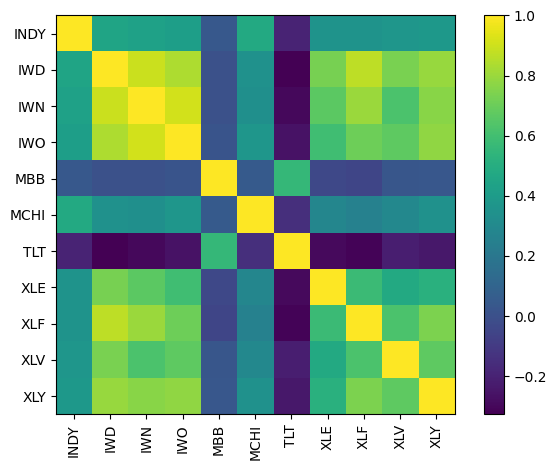

In [42]:
plotting.plot_covariance(S, plot_correlation=True);

In [43]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

,0
Ticker,
INDY,0.042819
IWD,0.098100
IWN,0.113387
IWO,0.114000
MBB,0.001005
MCHI,0.039336
TLT,-0.020313
XLE,0.113177
XLF,0.142368


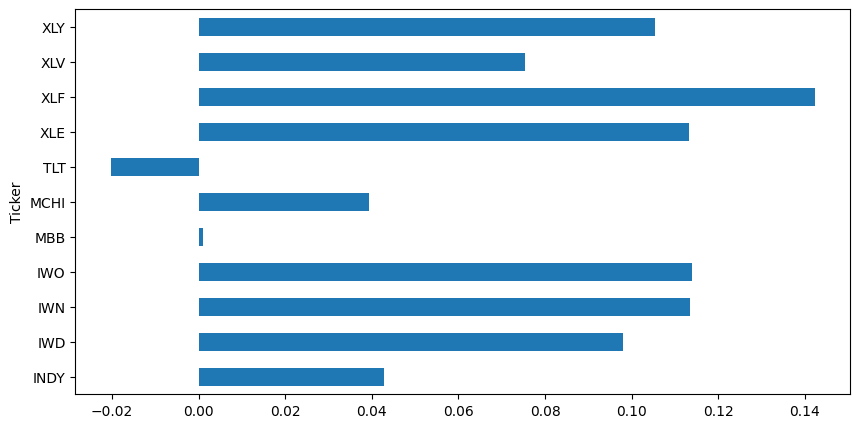

In [44]:
market_prior.plot.barh(figsize=(10,5));

## Views

In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to.

If you are providing **absolute views** (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary.

In [49]:
#Exp_returns and volatility
# Define the date range (last 2 years)
from datetime import datetime, timedelta
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=2*365)).strftime('%Y-%m-%d')

# Download adjusted close price data for the tickers
data = yf.download(tickers, start=start_date, end=end_date)['Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Calculate the mean daily returns and volatility (standard deviation) for each asset
mean_daily_returns = returns.mean()
daily_volatility = returns.std()

# Annualize the mean returns and volatility
trading_days = 252  # Approximate number of trading days in a year
annualized_returns = mean_daily_returns * trading_days
annualized_volatility = daily_volatility * np.sqrt(trading_days)

# Calculate the covariance matrix for the asset classes (daily)
cov_matrix_daily = returns.cov()

# Annualize the covariance matrix
cov_matrix_annualized = cov_matrix_daily * trading_days

# Display results
print("Annualized Returns:\n", annualized_returns)
print("\nAnnualized Volatility:\n", annualized_volatility)
print("\nAnnualized Covariance Matrix:\n", cov_matrix_annualized)

[*********************100%***********************]  11 of 11 completed

Annualized Returns:
 Ticker
INDY    0.090402
IWD     0.135838
IWN     0.081951
IWO     0.125248
MBB     0.037643
MCHI    0.133967
TLT    -0.015929
XLE     0.089805
XLF     0.207169
XLV     0.081920
XLY     0.228448
dtype: float64

Annualized Volatility:
 Ticker
INDY    0.121136
IWD     0.117188
IWN     0.205911
IWO     0.204718
MBB     0.074045
MCHI    0.287987
TLT     0.160274
XLE     0.199117
XLF     0.151615
XLV     0.113002
XLY     0.186872
dtype: float64

Annualized Covariance Matrix:
 Ticker      INDY       IWD       IWN       IWO       MBB      MCHI       TLT  \
Ticker                                                                         
INDY    0.014674  0.006535  0.010797  0.011563  0.001215  0.006649  0.001942   
IWD     0.006535  0.013733  0.021146  0.019982  0.001366  0.009858  0.002135   
IWN     0.010797  0.021146  0.042399  0.038926  0.002988  0.016006  0.004300   
IWO     0.011563  0.019982  0.038926  0.041909  0.002868  0.015804  0.003918   
MBB     0.001215  0.0013

In [50]:

# Convert the annualized returns to a dictionary
annualized_returns_dict = annualized_returns.to_dict()

# Define your absolute views using the values from the 'annualized_returns' variable
# From my capital market Expectations I expect the given asset classes can provide a return which is atleast the mean.

viewdict = {ticker: annualized_returns_dict[ticker] for ticker in annualized_returns_dict}

# Now pass this into the Black-Litterman model
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

print("Views:", viewdict)

Views: {'INDY': 0.09040211316445225, 'IWD': 0.13583809204090155, 'IWN': 0.08195078156209978, 'IWO': 0.12524782359594291, 'MBB': 0.03764294155990762, 'MCHI': 0.13396674894130192, 'TLT': -0.015929111881318944, 'XLE': 0.08980529655597475, 'XLF': 0.20716858120709553, 'XLV': 0.0819199330555198, 'XLY': 0.22844824634263378}


Black-Litterman also allows for relative views, e.g you think asset A will outperform asset B by 10%. If you'd like to incorporate these, you will have to build P and Q yourself. An explanation for this is given in the [docs](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#views).

## View confidences

In this section, we provide two ways that you may wish to construct the uncertainty matrix. The first is known as Idzorek's method. It allows you to specify a vector/list of percentage confidences.

In [51]:
confidences = [
    0.4,#INDY
    0.7,#IWD
    0.45,#IWM
    0.55,#IWO
    0.35, #MBB
    0.65, #MCHI
    0.45, #TLT
    0.7, #XLE
    0.6, #XLF
    0.32, #XLV
    0.45 #XLY
]

In [52]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

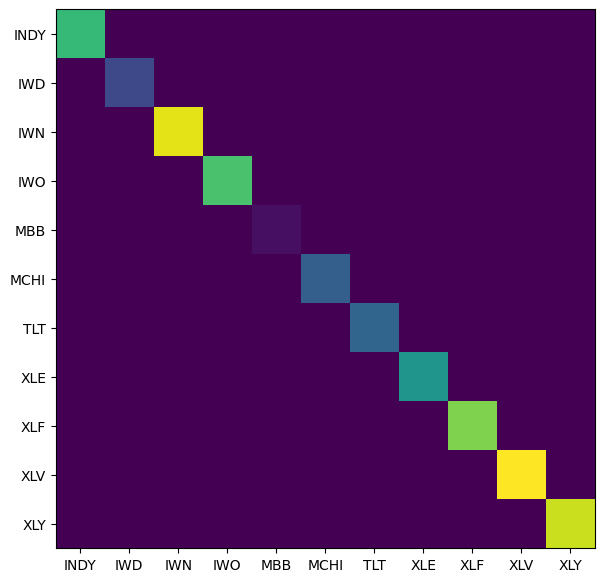

In [53]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [54]:
np.diag(bl.omega)

array([0.002274  , 0.0007462 , 0.00325686, 0.00242246, 0.00014522,
       0.00102455, 0.00110869, 0.00177345, 0.00274422, 0.0033998 ,
       0.00312853])

Note how NAT, which we gave the lowest confidence, also has the highest uncertainty.

Instead of inputting confidences, we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [56]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

In [57]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]


## Posterior estimates

Given the inputs, we can compute a posterior estimate of returns


In [60]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega="idzorek",view_confidences=confidences)

In [61]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

,0
Ticker,
INDY,0.077143
IWD,0.125666
IWN,0.136905
IWO,0.143643
MBB,0.013750
MCHI,0.103857
TLT,-0.008156
XLE,0.112478
XLF,0.184820


We can visualise how this compares to the prior and our views:

In [62]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
INDY,0.042819,0.077143,0.090402
IWD,0.098100,0.125666,0.135838
IWN,0.113387,0.136905,0.081951
IWO,0.114000,0.143643,0.125248
MBB,0.001005,0.013750,0.037643
MCHI,0.039336,0.103857,0.133967
TLT,-0.020313,-0.008156,-0.015929
XLE,0.113177,0.112478,0.089805
XLF,0.142368,0.184820,0.207169
XLV,0.075465,0.100274,0.081920


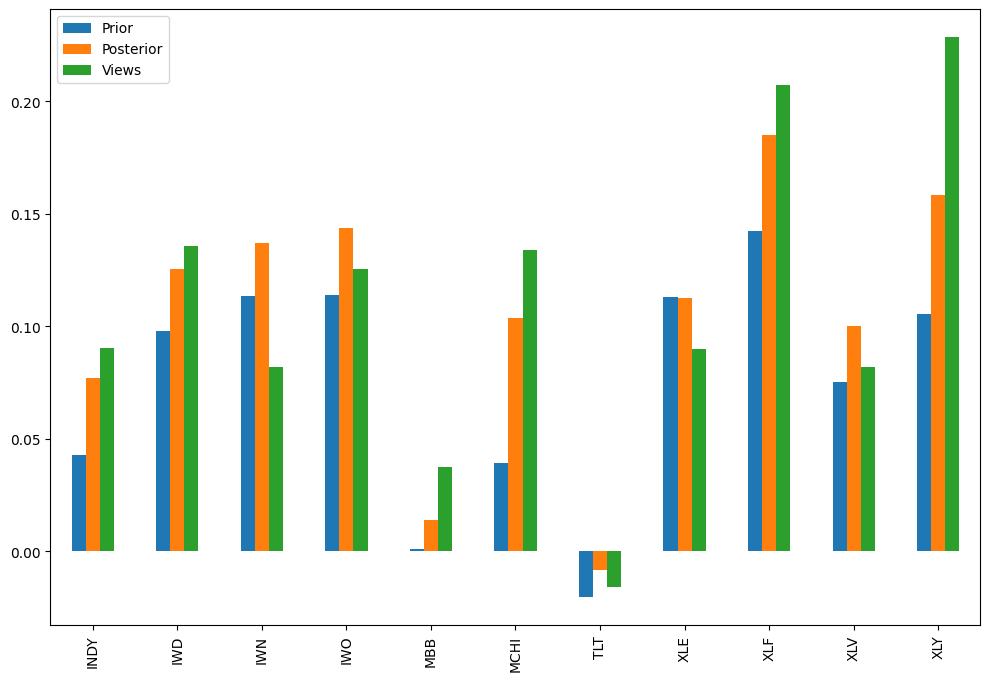

In [63]:
rets_df.plot.bar(figsize=(12,8));

Notice that the posterior is often between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

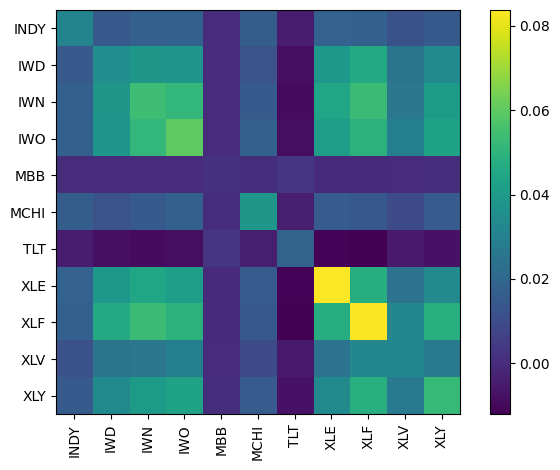

In [64]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

## Portfolio allocation

Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimizers discussed in previous recipes.

In [65]:
from pypfopt import EfficientFrontier, objective_functions

In [66]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/usr/local/lib/python3.11/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('INDY', 0.06921),
             ('IWD', 0.10767),
             ('IWN', 0.1136),
             ('IWO', 0.12025),
             ('MBB', 0.01532),
             ('MCHI', 0.0992),
             ('TLT', 0.0),
             ('XLE', 0.08689),
             ('XLF', 0.15987),
             ('XLV', 0.08716),
             ('XLY', 0.14083)])

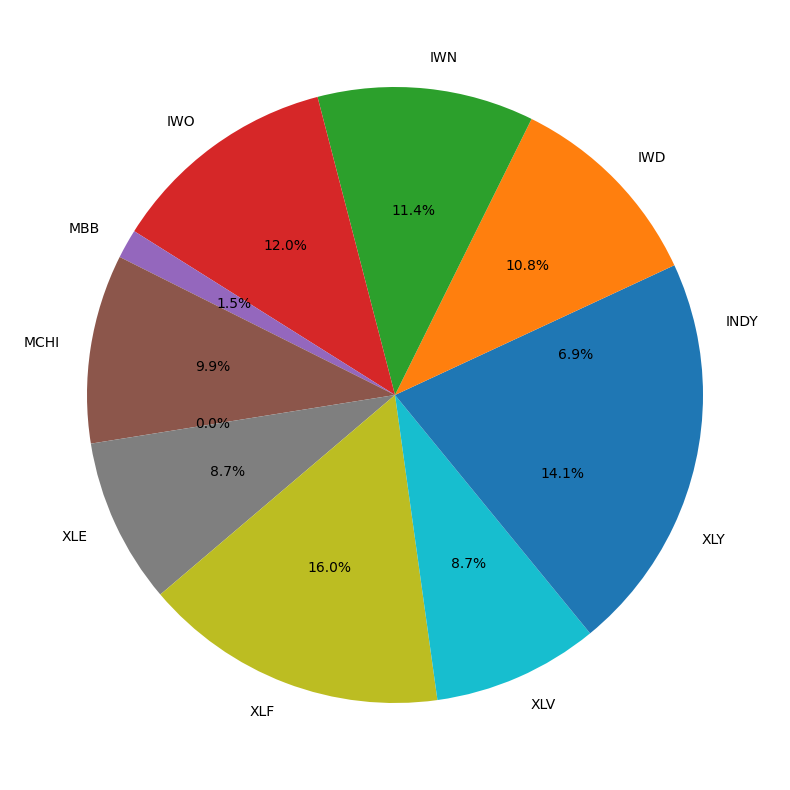

In [69]:
pd.Series(weights).plot.pie(figsize=(10,10,),autopct='%1.1f%%');

In [68]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $0.95


{'INDY': 28,
 'IWD': 11,
 'IWN': 14,
 'IWO': 9,
 'MBB': 3,
 'MCHI': 35,
 'XLE': 19,
 'XLF': 62,
 'XLV': 12,
 'XLY': 13}